**Version: 1.0.1**

If you encounter any errors, please contact me. I will complete the verification and make corrections as soon as possible.

# Usage Guide

This code consists of three sections: AutoML, Interpretability Analysis, and Exploratory Factor Analysis (EFA).
When using this code, please remember to cite this article. 
Each section includes detailed comments, so please modify the respective variables according to the comments to complete your research.

0. **Preoaration**
1. **AutoML**: Utilize AutoML tools for model training and optimization.
2. **Interpretability Analysis**: Use tools like SHAP for model interpretability analysis to identify important features and their relationships.
3. **Exploratory Factor Analysis (EFA)**: Conduct EFA to uncover the underlying factor structure in the data.

Please adjust the respective variables and parameters according to your specific needs to fit your research data and objectives.


# 0 Preparation

In this section, you need to import the necessary libraries for the code to function correctly. Ensure that each library is successfully imported before proceeding with further steps.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy import stats
import shap
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo, Rotator
from sklearn.decomposition import PCA

## 0.1 Data Import
**Feature Engineering**

In this section, you need to import your data and ensure it is converted into a tabular format, with the first row containing the column names. Modify the file path to the CSV file that contains your data.

In [2]:
# Modify the file path to point to your CSV data file
# Load the data into a pandas DataFrame
file_path = '/Users/sunxinru/Desktop/ML/Data/Example Data.csv'
data=pd.read_csv(file_path,header=0) 
# Display the first few rows of the data to verify successful import
print(data.head())

   Num  Gender  Age  Grade  Major  Only child  Residence  \
0    1       1   21      4      1           1        1.0   
1    2       1   22      4      2           2        2.0   
2    3       2   22      4      2           2        2.0   
3    4       2   22      4      2           1        2.0   
4    5       2   21      4      2           1        1.0   

   Number of online groups  Internet age  Daily online duration  ...  PANAS10  \
0                      3.0           4.0                    2.0  ...        4   
1                      1.0           4.0                    1.0  ...        1   
2                      3.0           4.0                    2.0  ...        1   
3                      1.0           4.0                    3.0  ...        3   
4                      3.0           4.0                    1.0  ...        3   

   PANAS11  PANAS12  PANAS13  PANAS14  PANAS15  PANAS16  PANAS17  PANAS18  \
0        5      4.0        5        2      5.0        4        5      5.0  

## 0.2 Data Selection

In psychological research, not all features are necessarily included in the analysis. 
Therefore, after `data.iloc`, input all the variables you wish to include (including the dependent variable). 
Modify the line `target = data['CD-RISC']` by replacing `CD-RISC` with the name of your dependent variable as it appears in your CSV file.

In [3]:
# Modify with the columns you need
features = data.iloc[:, 1:44]

# Modify 'CD-RISC' to the name of your dependent variable
target = data['CD-RISC']

data = pd.concat([features, target], axis=1)
for column in data.columns:
    if pd.api.types.is_numeric_dtype(data[column]):
        data[column] = data[column].astype('float')

## 0.3 Handling Anomalies
To facilitate checking for anomalies in the data, count the unique values in each column. 
For example, we can see an anomaly in the "Age" column. There is an erroneous value: `Value: 2.0, Count: 1`, where the age was mistakenly entered as 2.
You can follow this example to modify and handle the anomalies in your data. Adjust the variable name and the range according to your needs.

In [4]:
# Count unique values in each column to check for anomalies
for column in data.columns:
    print(f"Column: {column}")
    value_counts = data[column].value_counts(dropna=False)
    for value, count in value_counts.items():
        print(f"Value: {value}, Count: {count}")
    print("\n")

Column: Gender
Value: 1.0, Count: 314
Value: 2.0, Count: 274
Value: 3.0, Count: 2


Column: Age
Value: 20.0, Count: 205
Value: 19.0, Count: 157
Value: 21.0, Count: 113
Value: 18.0, Count: 53
Value: 22.0, Count: 48
Value: 23.0, Count: 11
Value: 24.0, Count: 2
Value: 2.0, Count: 1


Column: Grade
Value: 2.0, Count: 284
Value: 3.0, Count: 132
Value: 1.0, Count: 108
Value: 4.0, Count: 62
Value: 5.0, Count: 4


Column: Major
Value: 1.0, Count: 213
Value: 5.0, Count: 173
Value: 2.0, Count: 171
Value: 3.0, Count: 24
Value: 4.0, Count: 9


Column: Only child
Value: 2.0, Count: 314
Value: 1.0, Count: 276


Column: Residence
Value: 2.0, Count: 331
Value: 1.0, Count: 257
Value: 3.0, Count: 1
Value: nan, Count: 1


Column: Number of online groups
Value: 3.0, Count: 231
Value: 1.0, Count: 203
Value: 2.0, Count: 92
Value: 4.0, Count: 61
Value: nan, Count: 3


Column: Internet age
Value: 4.0, Count: 383
Value: 3.0, Count: 106
Value: 2.0, Count: 64
Value: 1.0, Count: 28
Value: nan, Count: 9


Column: 

In [5]:
#To address anomalies, replace values in the "Age" column that are less than 18 or greater than 24 with null values.
data.loc[(data['Age'] < 18) | (data['Age'] > 24), 'Age'] = np.nan

In [6]:
# View Missing Value Proportions
null_ratio = data.isnull().mean()
print(null_ratio)

Gender                          0.000000
Age                             0.001695
Grade                           0.000000
Major                           0.000000
Only child                      0.000000
Residence                       0.001695
Number of online groups         0.005085
Internet age                    0.015254
Daily online duration           0.003390
Number of friends met online    0.008475
SES7                            0.005085
SES3                            0.000000
SES9R                           0.000000
SES4                            0.001695
SES5R                           0.000000
SES10                           0.001695
SES1                            0.001695
SES8R                           0.000000
SES6R                           0.000000
SES2R                           0.000000
SWLS1                           0.003390
SWLS2                           0.000000
SWLS3                           0.001695
SWLS4                           0.000000
SWLS5           

In [7]:
# Filling Missing Values with Mean
# data.fillna(data.mean(), inplace=True)
# Filling Missing Values with Median
# data.fillna(data.median(), inplace=True)
# Filling Missing Values with Mode
data.fillna(data.mode().iloc[0], inplace=True)

## 0.4 Data Standardization or Normalization

In this section, you will standardize or normalize the selected columns in your dataset. 
Standardization transforms the data to have a mean of 0 and a standard deviation of 1. 
Normalization scales the data to a range between 0 and 1.

In [8]:
# Extract the columns to be standardized
columns_to_scale = ['Age'] + list(data.columns[6:43])
# Initialize the StandardScaler
scaler = StandardScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
# Initialize the MinMaxScaler
# min_max_scaler = MinMaxScaler()
# data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

## 0.5 Encoding Categorical Variables

Psychological research often involves many categorical variables. We can handle these by applying one-hot encoding to convert them into a format suitable for machine learning algorithms.

In [9]:
# List of categorical columns to be encoded
# Replace with your categorical columns
columns_to_encode = ['Gender','Grade', 'Major', 'Only child', 'Residence']
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical features
encoded_features = encoder.fit_transform(data[columns_to_encode])
# Convert encoded features to a DataFrame
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
# Reset index to match the original DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=data.index)

# Drop the original categorical columns from the data
data.drop(columns=columns_to_encode, inplace=True)
data = pd.concat([data, encoded_df], axis=1)
data.head()

,Age,Number of online groups,Internet age,Daily online duration,Number of friends met online,SES7,SES3,SES9R,SES4,SES5R,...,Major_1.0,Major_2.0,Major_3.0,Major_4.0,Major_5.0,Only child_1.0,Only child_2.0,Residence_1.0,Residence_2.0,Residence_3.0
0,0.875126,0.710423,0.622291,0.167699,-0.533661,1.365529,1.543968,1.291074,-2.976179,1.904538,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.731386,-1.207881,0.622291,-0.969568,-0.533661,-1.461356,-1.613540,0.089601,0.099032,-0.658010,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.731386,0.710423,0.622291,0.167699,0.336118,-1.461356,-0.034786,-1.111871,-1.438574,-1.939285,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.731386,-1.207881,0.622291,1.304965,-0.533661,-1.461356,-0.034786,-1.111871,0.099032,-0.658010,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.875126,0.710423,0.622291,-0.969568,1.205897,-0.047913,-0.034786,1.291074,0.099032,-0.658010,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


# 1. AutoML Section

In this section, we will use AutoML tools to train and optimize machine learning models. AutoML simplifies the process of model selection, hyperparameter tuning, and performance evaluation.

This section will guide you through splitting your data, training a machine learning model using AutoGluon, and evaluating its performance on the test set. AutoGluon handles many of the complexities of model training and tuning, making it easier to achieve high-quality results with minimal effort. Adjust the split ratio (frac=0.8) and the evaluation metric (eval_metric='accuracy') based on your specific needs.

In [10]:
# Load Data
data = TabularDataset(data)

In [11]:
# Split data into training and testing sets
train_data = data.sample(frac=0.8, random_state=42)  # 80% for training, adjust frac as needed
test_data = data.drop(train_data.index)  # 20% for testing
train_data.head()
label = 'CD-RISC'
train_data[label].describe()


count    472.000000
mean      64.116525
std       12.109075
min       32.000000
25%       57.000000
50%       63.000000
75%       72.000000
max       98.000000
Name: CD-RISC, dtype: float64

## 1.1 Training the Model
Use AutoGluon to train a model on the training data. Adjust the evaluation metric (eval_metric) as needed, such as f1, recall, roc_auc, etc.

In [12]:
# Training the Model.Use AutoGluon to train a model on the training data.
#presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
#presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
#presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
#presets='medium_quality' : Fast training time, ideal for initial prototyping.
save_path = 'agModels-predictClass'
# Train the model using AutoGluon
predictor = TabularPredictor(label='CD-RISC').fit(train_data, presets='best_quality',auto_stack=True)
# Display a summary of the training process
predictor.fit_summary()

No path specified. Models will be saved in: "AutogluonModels/ag-20250901_003717"


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       4.49 GB / 16.00 GB (28.1%)
Disk Space Avail:   668.60 GB / 926.35 GB (72.2%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. C

(_ray_fit pid=70193) [1000]	valid_set's rmse: 10.6925


(_dystack pid=69963) 	-9.6354	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	1.19s	 = Training   runtime
(_dystack pid=69963) 	0.01s	 = Validation runtime
(_dystack pid=69963) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 518.19s of the 815.44s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=69963) 	-9.3766	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	2.67s	 = Training   runtime
(_dystack pid=69963) 	0.04s	 = Validation runtime
(_dystack pid=69963) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 512.89s of the 810.13s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=4.47%)
(_dystack pid=69963) 	-10.0018	 = Validation score   (-root_mean_squared_er

(_ray_fit pid=70570) [1000]	valid_set's rmse: 10.9649
(_ray_fit pid=70572) [1000]	valid_set's rmse: 8.13418


(_dystack pid=69963) 	-9.6919	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	2.31s	 = Training   runtime
(_dystack pid=69963) 	0.04s	 = Validation runtime
(_dystack pid=69963) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 404.65s of the 701.90s of remaining time.
(_ray_fit pid=70551) No improvement since epoch 7: early stopping [repeated 6x across cluster]
(_dystack pid=69963) 	-9.6191	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	0.51s	 = Training   runtime
(_dystack pid=69963) 	0.04s	 = Validation runtime
(_dystack pid=69963) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 404.09s of the 701.33s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=8.71%)
(_dystack pid=69963) 	-9.779	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	1.27s	 = Training   runtime
(_dyst

(_ray_fit pid=70765) [1000]	valid_set's rmse: 11.1087 [repeated 4x across cluster]


(_dystack pid=69963) 	-9.5196	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	1.35s	 = Training   runtime
(_dystack pid=69963) 	0.01s	 = Validation runtime
(_dystack pid=69963) Fitting model: RandomForest_r127_BAG_L1 ... Training model for up to 344.05s of the 641.29s of remaining time.
(_dystack pid=69963) 	-9.6097	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	0.64s	 = Training   runtime
(_dystack pid=69963) 	0.04s	 = Validation runtime
(_dystack pid=69963) Fitting model: NeuralNetFastAI_r134_BAG_L1 ... Training model for up to 343.35s of the 640.60s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=70779) No improvement since epoch 2: early stopping
(_dystack pid=69963) 	-9.8052	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	5.79s	 = Training   runtime
(_dystack pid=69963) 	0.08

(_ray_fit pid=70953) [1000]	valid_set's rmse: 10.261 [repeated 2x across cluster]


(_dystack pid=69963) 	-9.6868	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	1.56s	 = Training   runtime
(_dystack pid=69963) 	0.01s	 = Validation runtime
(_dystack pid=69963) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 282.86s of the 580.11s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.06%)
(_ray_fit pid=70926) No improvement since epoch 27: early stopping [repeated 6x across cluster]
(_dystack pid=69963) 	-9.9848	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	0.49s	 = Training   runtime
(_dystack pid=69963) 	0.02s	 = Validation runtime
(_dystack pid=69963) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 279.13s of the 576.38s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, 

(_ray_fit pid=71607) [1000]	valid_set's rmse: 9.68532
(_ray_fit pid=71607) [2000]	valid_set's rmse: 9.63595
(_ray_fit pid=71607) [3000]	valid_set's rmse: 9.62746
(_ray_fit pid=71607) [4000]	valid_set's rmse: 9.62566
(_ray_fit pid=71607) [5000]	valid_set's rmse: 9.62538
(_ray_fit pid=71607) [6000]	valid_set's rmse: 9.62532
(_ray_fit pid=71607) [7000]	valid_set's rmse: 9.62529
(_ray_fit pid=71607) [8000]	valid_set's rmse: 9.62528
(_ray_fit pid=71607) [9000]	valid_set's rmse: 9.62528
(_ray_fit pid=71607) [10000]	valid_set's rmse: 9.62528


(_dystack pid=69963) 	-9.3565	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	2.99s	 = Training   runtime
(_dystack pid=69963) 	0.03s	 = Validation runtime
(_dystack pid=69963) Fitting model: LightGBM_BAG_L2 ... Training model for up to 372.08s of the 371.84s of remaining time.
(_dystack pid=69963) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.72%)
(_dystack pid=69963) 	-9.3867	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	1.4s	 = Training   runtime
(_dystack pid=69963) 	0.01s	 = Validation runtime
(_dystack pid=69963) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 368.27s of the 368.03s of remaining time.
(_dystack pid=69963) 	-9.5329	 = Validation score   (-root_mean_squared_error)
(_dystack pid=69963) 	0.48s	 = Training   runtime
(_dystack pid=69963) 	0.1s	 = Validation runtime
(_dystack pid=69963) Fitting model: CatBoost_BAG_L2 ... Tr

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L3  -8.875725  root_mean_squared_error       0.384770  16.956097                0.000477           0.010947            3       True        214
1            WeightedEnsemble_L2  -8.943419  root_mean_squared_error       0.139094   9.828236                0.000135           0.005185            2       True        107
2             XGBoost_r31_BAG_L2  -9.022220  root_mean_squared_error       0.286208  12.315353                0.032268           0.526901            2       True        180
3           CatBoost_r137_BAG_L2  -9.072679  root_mean_squared_error       0.274265  13.155025                0.020325           1.366573            2       True        126
4             CatBoost_r6_BAG_L2  -9.083694  root_mean_squared_error     

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_r22_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'XGBoost_r33_BAG_L1': 'S

In [13]:
# Evaluate the model on the test data
predictor.evaluate(test_data)

{'root_mean_squared_error': -8.906863038203907,
 'mean_squared_error': -79.33220918132294,
 'mean_absolute_error': -6.56933891167075,
 'r2': 0.4350157146835538,
 'pearsonr': 0.6705748561635685,
 'median_absolute_error': -4.90031623840332}

In [14]:
# Display the best model
predictor.model_best

'WeightedEnsemble_L3'

## 1.2 Model Leaderboard

View the leaderboard to see the performance of different models trained by AutoGluon.

In [15]:
# Display the leaderboard for models trained by AutoGluon on the test data
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_r14_BAG_L2,-8.658612,-9.467725,root_mean_squared_error,0.205873,0.290771,14.815696,0.025886,0.036832,3.027243,2,True,142
1,NeuralNetTorch_r158_BAG_L2,-8.894097,-9.394628,root_mean_squared_error,0.214469,0.343909,17.097211,0.034482,0.089969,5.308759,2,True,154
2,NeuralNetTorch_r143_BAG_L1,-8.897690,-9.381971,root_mean_squared_error,0.044788,0.031845,3.400469,0.044788,0.031845,3.400469,1,True,58
3,WeightedEnsemble_L3,-8.906863,-8.875725,root_mean_squared_error,0.302570,0.384770,16.956097,0.001126,0.000477,0.010947,3,True,214
4,NeuralNetTorch_r14_BAG_L1,-8.919630,-9.444147,root_mean_squared_error,0.022240,0.037921,3.097030,0.022240,0.037921,3.097030,1,True,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,RandomForest_r34_BAG_L1,-9.909900,-10.108769,root_mean_squared_error,0.016230,0.048332,0.319334,0.016230,0.048332,0.319334,1,True,56
210,NeuralNetFastAI_r172_BAG_L2,-10.000568,-9.811626,root_mean_squared_error,0.221857,0.310186,15.739038,0.041870,0.056247,3.950586,2,True,191
211,NeuralNetFastAI_r65_BAG_L1,-10.127813,-9.827345,root_mean_squared_error,0.043833,0.039425,3.059276,0.043833,0.039425,3.059276,1,True,63
212,NeuralNetFastAI_r156_BAG_L1,-10.153618,-10.007269,root_mean_squared_error,0.053385,0.031891,2.991932,0.053385,0.031891,2.991932,1,True,39


# 2. Interpretability Analysis

In this section, we will use SHAP (SHapley Additive exPlanations) to perform interpretability analysis on the trained model. This helps to identify important features and understand their impact on the model's predictions.

## 2.1 AutoGluon Wrapper for SHAP

This section defines a wrapper class for the AutoGluon predictor, making it compatible with SHAP for interpretability analysis. This part of the code is adapted from the work of AutoGluon developers.

In [16]:
# Initialize the SHAP environment
shap.initjs()

class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

**Using the Training Set vs. Test Set for SHAP Explainer**

When creating a SHAP explainer, you have the option to use either the training set or the test set as the baseline. Using the training set as the baseline ensures that SHAP values are calculated based on the same data that the model was trained on, which helps in interpreting the model's behavior on familiar data and maintaining consistency with model training. However, it may not generalize well to new data and could reflect any biases present in the training data. On the other hand, using the test set as the baseline provides SHAP values that better represent the model's performance on unseen data, offering a less biased and more generalizable evaluation. It helps in understanding the model's behavior on real-world data but may lack the training context and could risk data leakage if not used properly. Choose the baseline based on your specific goals for interpretability analysis.


In [17]:
# Extract the features (X) and target variable (y)
X_train = train_data.drop(columns=['CD-RISC'])# Replace with your target variable name
y_train = train_data['CD-RISC']# Replace with your target variable name
X_test = test_data.drop(columns=['CD-RISC'])# Replace with your target variable name
y_test = test_data['CD-RISC']# Replace with your target variable name

In [18]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))

In [19]:
label = 'CD-RISC'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
val_data = X_test.copy()

display(train_data.head())

,Age,Number of online groups,Internet age,Daily online duration,Number of friends met online,SES7,SES3,SES9R,SES4,SES5R,...,Major_2.0,Major_3.0,Major_4.0,Major_5.0,Only child_1.0,Only child_2.0,Residence_1.0,Residence_2.0,Residence_3.0,CD-RISC
522,-1.693652,0.710423,-0.532274,0.167699,-1.403440,-1.461356,-0.034786,-1.111871,-1.438574,-0.658010,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,38.0
284,0.018867,-1.207881,0.622291,-0.969568,-0.533661,1.365529,1.543968,-1.111871,0.099032,0.623264,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,58.0
514,-0.837393,-1.207881,0.622291,-0.969568,1.205897,1.365529,1.543968,0.089601,0.099032,0.623264,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,64.0
331,-0.837393,-1.207881,-1.686840,1.304965,1.205897,-0.047913,-0.034786,-2.313343,0.099032,-0.658010,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,78.0
210,0.018867,0.710423,0.622291,-0.969568,0.336118,-0.047913,-0.034786,1.291074,0.099032,1.904538,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,59.0


In [20]:
X_train_summary = shap.kmeans(X_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


In [21]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

Root mean squared test error = 8.906863038203907


In [ ]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values,X_train)

  0%|          | 0/472 [00:00<?, ?it/s]

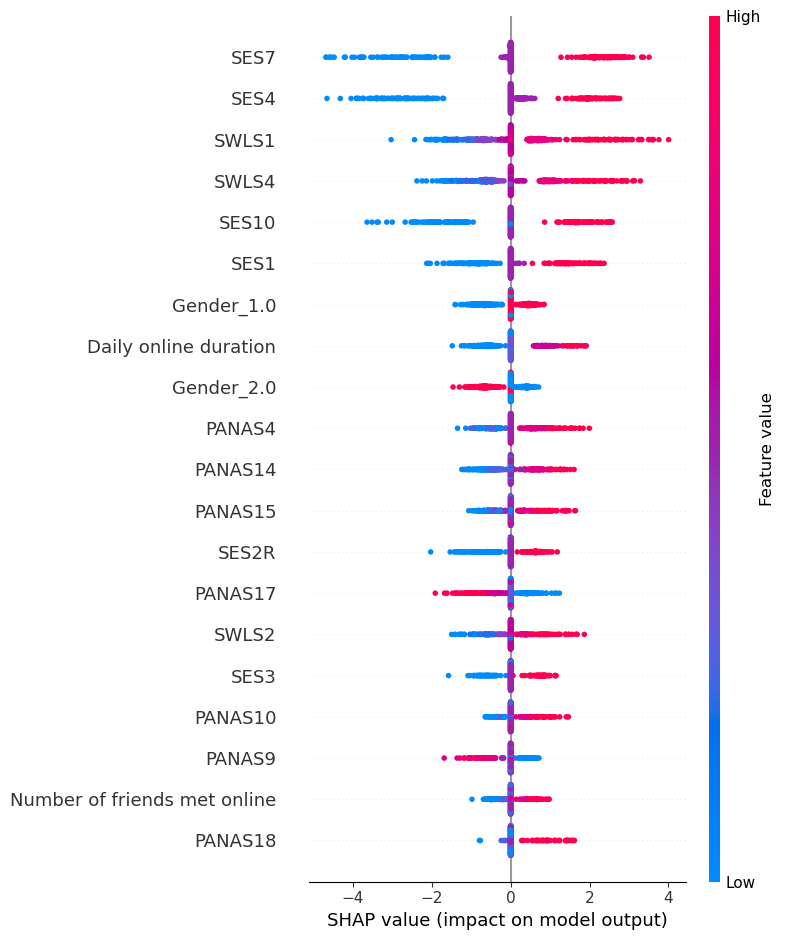

In [24]:
# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_train)

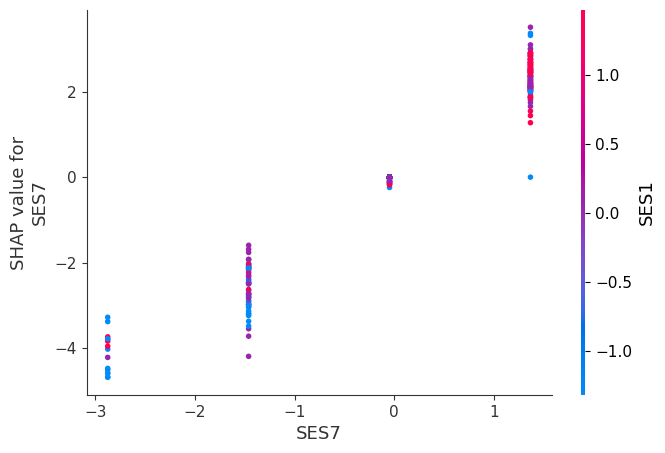

In [25]:
# Generate a SHAP dependence plot for the feature "SES7"
# In this section, we will generate a SHAP dependence plot to visualize the relationship between a specific feature and the model's predictions using the calculated SHAP values.
shap.dependence_plot("SES7", shap_values,X_train)

# 3. Exploratory Factor Analysis (EFA)

In this section, we will perform Exploratory Factor Analysis (EFA) to uncover the underlying factor structure in the data. EFA helps in identifying the latent variables that explain the patterns in the observed variables.

## 3.1 Preparing Data for EFA

To perform Exploratory Factor Analysis (EFA), we need to calculate the importance of variables and exclude those that do not meet a certain threshold. In this case, we will include variables that contribute up to 80% of the total importance and exclude demographic variables.

In [26]:
# Calculate cumulative importance
shap_values_train = np.array(shap_values)  
feature_importance = np.mean(np.abs(shap_values_train), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df['cumulative_importance'] /= feature_importance_df['importance'].sum()

In [27]:
# Determine the number of features to reach 80% importance
threshold = 0.8
num_important_features = (feature_importance_df['cumulative_importance'] <= threshold).sum()
print(f"Number of features to reach {threshold*100}% of importance: {num_important_features}")

Number of features to reach 80.0% of importance: 13


In [28]:
# Printing the Names and Importance of the Top 24 Features
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

                  feature  importance
5                    SES7    0.984972
8                    SES4    0.908095
15                  SWLS1    0.784647
18                  SWLS4    0.730273
10                  SES10    0.645517
11                   SES1    0.500370
38             Gender_1.0    0.402686
3   Daily online duration    0.361869
39             Gender_2.0    0.349176
23                 PANAS4    0.343212
33                PANAS14    0.323415
34                PANAS15    0.289612
14                  SES2R    0.279178


# Printing the Names and Importance of the Top Features
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

In [29]:
# Exclude demographic variables
variables_to_remove = ['Gender_1.0', 'Gender_2.0','Daily online duration']
important_feature_names = [feature for feature in important_feature_names if feature not in variables_to_remove]
important_data = data[important_feature_names]

## 3.2 Parallel Analysis to Determine the Number of Factors

To determine the appropriate number of factors for Exploratory Factor Analysis (EFA), we perform parallel analysis. This method compares the eigenvalues from the actual data with those from randomly generated data.

**Bartlett's Test of Sphericity:** This test assesses whether the correlation matrix is an identity matrix, which would indicate that variables are unrelated. A significant result (p-value < 0.05) suggests that the correlation matrix is not an identity matrix, implying that the data is suitable for factor analysis.

**KMO Test:** The KMO test evaluates the adequacy of the correlation matrix for factor analysis. It measures the proportion of variance among variables that might be common variance. The KMO statistic ranges from 0 to 1, with values closer to 1 indicating that the data is suitable for factor analysis.


In [30]:
def calculate_rmsea(chi_square, dof, n):
    rmsea = np.sqrt((chi_square - dof) / (dof * (n - 1)))
    return rmsea

def calculate_tli(chi_square, dof, chi_square_null, dof_null):
    tli = 1 - (chi_square / dof) / (chi_square_null / dof_null)
    return tli

# Bartlett's Test of Sphericity
# To ensure that the variables are sufficiently correlated for factor analysis, we perform Bartlett's Test of Sphericity. This test checks whether the correlation matrix is significantly different from an identity matrix.
bartlett_test, p_value = calculate_bartlett_sphericity(important_data)
print(f"Bartlett's Test: Chi-square = {bartlett_test}, p-value = {p_value}")

# Perform the Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(important_data)
print(f"KMO Test: {kmo_model}")

Bartlett's Test: Chi-square = 1178.9551519674537, p-value = 1.5747355666107711e-217
KMO Test: 0.7891864977223997


**Parallel Analysis (Simplified Implementation)**

Determines optimal number of factors by comparing eigenvalues from actual data with those derived from random data using PCA, calculating mean random eigenvalues (mean_random_eigenvalues) as a threshold for component retention

In [ ]:
def parallel_analysis(data, n_iterations=1000):
    n_samples, n_features = data.shape
    random_eigenvalues = np.zeros((n_iterations, n_features))
    for i in range(n_iterations):
        random_data = np.random.normal(size=data.shape)
        pca = PCA()
        pca.fit(random_data)
        random_eigenvalues[i, :] = pca.explained_variance_
    mean_random_eigenvalues = random_eigenvalues.mean(axis=0)
    return mean_random_eigenvalues

pca = PCA()
pca.fit(important_data)
eigenvalues = pca.explained_variance_
mean_random_eigenvalues = parallel_analysis(important_data)
num_factors = np.sum(eigenvalues > mean_random_eigenvalues)
print(f"Number of factors to retain based on parallel analysis: {num_factors}")

Number of factors to retain based on parallel analysis: 3


In [32]:
# Create the FactorAnalyzer object, specifying the number of factors to retain
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(important_data)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [33]:
# Get the factor loadings
loadings = fa.loadings_
variable_names = important_data.columns.tolist()
num_factors = loadings.shape[1]
factor_names = [f'Factor{i+1}' for i in range(num_factors)]
factor_loadings_df = pd.DataFrame(loadings, index=variable_names,columns=factor_names)
# Remove loadings with absolute values less than 0.3
factor_loadings_df = factor_loadings_df.where(abs(factor_loadings_df) >= 0.3, '')
print("Factor Loadings: \n", factor_loadings_df)

Factor Loadings: 
           Factor1   Factor2   Factor3
SES7     0.659584                    
SES4     0.482286                    
SWLS1                        0.891006
SWLS4                        0.391785
SES10    0.680061                    
SES1     0.604434                    
PANAS4             0.687603          
PANAS14            0.709441          
PANAS15            0.683796          
SES2R    0.323103                    


In [34]:
#Evaluation of the Factor Analysis Model
# Sample and variable counts
n = important_data.shape[0]
p = important_data.shape[1]

# Calculate correlation matrix
corr_matrix = np.corrcoef(important_data, rowvar=False)

# Get loadings and uniquenesses
loadings = fa.loadings_
uniquenesses = 1 - np.sum(loadings**2, axis=1)

# Calculate model-implied correlation matrix
model_corr = loadings @ loadings.T
np.fill_diagonal(model_corr, model_corr.diagonal() + uniquenesses)

# Calculate chi-square using maximum likelihood method
log_det_corr = np.log(np.linalg.det(corr_matrix))
log_det_model = np.log(np.linalg.det(model_corr))
trace = np.trace(corr_matrix @ np.linalg.inv(model_corr)) - p
chi_square = (n - 1) * (log_det_model + trace - log_det_corr)

# Calculate degrees of freedom
dof = (p * (p + 1)) / 2 - (p * num_factors + p - (num_factors * (num_factors - 1)) / 2)

# Calculate null model chi-square
diag_corr = np.diag(np.diag(corr_matrix))
log_det_diag = np.log(np.linalg.det(diag_corr))
trace_null = np.trace(corr_matrix @ np.linalg.inv(diag_corr)) - p
chi_square_null = (n - 1) * (log_det_diag + trace_null - log_det_corr)
dof_null = p * (p - 1) / 2

# Calculate RMSEA 
rmsea = np.sqrt(max(0, (chi_square - dof) / (dof * (n - 1))))

# Calculate TLI
tli = ((chi_square_null / dof_null) - (chi_square / dof)) / ((chi_square_null / dof_null) - 1)

print(f"RMSEA: {rmsea:.4f}")
print(f"TLI: {tli:.4f}")
print(f"Chi-square: {chi_square:.4f}, df: {dof:.4f}")
print(f"p-value: {1 - stats.chi2.cdf(chi_square, dof):.4f}")

RMSEA: 0.0000
TLI: 1.0033
Chi-square: 16.5145, df: 18.0000
p-value: 0.5567


# # Extra Method 1: R and Python Interaction for Factor Analysis (Recommended)

The code utilizes the rpy2 interface to access R's psych package, preserving R's professional advantages in psychological statistical analysis while incorporating Python's flexibility and data processing capabilities. Users only need to provide appropriately formatted data files, and the system automatically handles R environment configuration, necessary package installation, data conversion, statistical analysis, and results presentation.

The framework supports multiple factor extraction methods and rotation techniques, while providing comprehensive model fit indicators such as RMSEA, TLI, and BIC. This integration delivers a powerful yet user-friendly solution for researchers and practitioners working with psychometric data, combining the best statistical tools from both programming ecosystems.



In [35]:
# Save the Data to CSV File
important_data.to_csv("factor_analysis_data_r.csv", index=False)
print("Factor analysis data successfully exported to factor_analysis_data.csv")

Factor analysis data successfully exported to factor_analysis_data.csv


In [52]:
# Set up R environment
import os
os.environ['R_HOME'] = r'/Library/Frameworks/R.framework/Versions/4.4.1/Resources'  # Use your correct R installation path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter

# Activate pandas to R data conversion
#pandas2ri.activate()
# 读取数据
df = pd.read_csv("/Users/sunxinru/Desktop/ML/Data/Example Data.csv")

# 在 with 语句里完成 DataFrame -> R data.frame 的转换
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df)

def run_parallel_analysis(data_path, fa_method="both", n_iter=100, fm="ml"):
    """
    Run parallel analysis on the data with the specified method.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV file containing the data.
    fa_method : str
        Method for parallel analysis. Options: "pc", "fa", or "both".
    n_iter : int
        Number of iterations for simulation.
    fm : str
        Factor extraction method. Options: "ml", "minres", "pa", etc.
        
    Returns:
    --------
    dict
        A dictionary containing the analysis results.
    """
    try:
        # Import R base packages
        base = importr('base')
        utils = importr('utils')
        psych = importr('psych')
        
        # Read data
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert data to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute parallel analysis
        print(f"Starting parallel analysis with method: {fa_method}...")
        ro.r('set.seed(123)')

        r_setup = """
        pdf(file=NULL) 
        """
        ro.r(r_setup)

        # Use R string to execute parallel analysis
        r_code = f"""
        parallel_result <- function(df) {{
          library(psych)
          result <- fa.parallel(df, fa="{fa_method}", fm="{fm}", n.iter={n_iter}, sim=TRUE, show=FALSE)
          dev.off()  
          return(result)
        }}
        """
        ro.r(r_code)
        parallel_result = ro.r('parallel_result')(r_df)
        
        # Extract results based on analysis method
        result = {}
        
        if fa_method in ["fa", "both"]:
            n_factors = parallel_result.rx2('nfact')[0]
            result["n_factors"] = n_factors
            print(f"Suggested number of factors: {n_factors}")
        
        if fa_method in ["pc", "both"]:
            n_components = parallel_result.rx2('ncomp')[0]
            result["n_components"] = n_components
            print(f"Suggested number of components: {n_components}")
        
        # Extract relevant eigenvalues based on method
        r_extract_values = f"""
        extract_values <- function(result) {{
          list(
            observed = if("{fa_method}" == "pc") result$pc.values else if("{fa_method}" == "fa") result$fa.values else NULL,
            simulated = if("{fa_method}" == "pc") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else if("{fa_method}" == "fa") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            fa_observed = if("{fa_method}" == "both") result$fa.values else NULL,
            fa_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            pc_observed = if("{fa_method}" == "both") result$pc.values else NULL,
            pc_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else NULL
          )
        }}
        """
        ro.r(r_extract_values)
        extracted_values = ro.r('extract_values')(parallel_result)
        
        # Convert R values to Python
        with localconverter(ro.default_converter + pandas2ri.converter):
            if fa_method in ["pc", "fa"]:
                observed = ro.conversion.rpy2py(extracted_values.rx2('observed'))
                simulated = ro.conversion.rpy2py(extracted_values.rx2('simulated'))
                result["observed"] = observed
                result["simulated"] = simulated
            elif fa_method == "both":
                fa_observed = ro.conversion.rpy2py(extracted_values.rx2('fa_observed'))
                fa_simulated = ro.conversion.rpy2py(extracted_values.rx2('fa_simulated'))
                pc_observed = ro.conversion.rpy2py(extracted_values.rx2('pc_observed'))
                pc_simulated = ro.conversion.rpy2py(extracted_values.rx2('pc_simulated'))
                result["fa_observed"] = fa_observed
                result["fa_simulated"] = fa_simulated
                result["pc_observed"] = pc_observed
                result["pc_simulated"] = pc_simulated
        
        # Save suggested factor numbers to file
        #with open(f'suggested_factors_{fa_method}.txt', 'w') as f:
        #    if fa_method in ["fa", "both"]:
        #        f.write(f"Suggested number of factors: {n_factors}\n")
        #    if fa_method in ["pc", "both"]:
        #        f.write(f"Suggested number of components: {n_components}")
        
       # print(f"Parallel analysis completed with method '{fa_method}' and results saved to text file.")
        
        return result
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Change this to the desired method: "pc", "fa", or "both"
    analysis_method = "both"
    
    # Run the analysis
    result = run_parallel_analysis("factor_analysis_data_r.csv", 
                                  fa_method=analysis_method,
                                  n_iter=100, 
                                  fm="pa")

R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In download.file(url, destfile = f, quiet = TRUE) :  
R callback write-console: 
   
R callback write-console:  unable to load shared object '/Library/Frameworks/R.framework/Versions/4.4.1/Resources/modules//internet.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.4.1/Resources/modules//internet.so, 0x0006): tried: '/Library/Frameworks/R.framework/Versions/4.4.1/Resources/modules//internet.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.4.1/Resources/modules//internet.so' (no such file), '/Library/Frameworks/R.framework/Versions/4.4.1/Resources/modules//internet.so' (no such file)
  
R callback write-console: Error in pdf(file = NULL) : failed to load default encoding
  
R callback write-console: In addition:   
R callback write-console: Warning message:
  
R callback write-console: In pdf(file = NULL) :  
R callb

Data successfully loaded: 590 rows and 10 columns
Starting parallel analysis with method: both...
An error occurred: Error in pdf(file = NULL) : failed to load default encoding



Traceback (most recent call last):
  File "/var/folders/py/wpd8rrgj3tz_mbdly_x8qmf80000gn/T/ipykernel_57438/691122659.py", line 60, in run_parallel_analysis
    ro.r(r_setup)
  File "/opt/anaconda3/lib/python3.12/site-packages/rpy2/robjects/__init__.py", line 549, in __call__
  File "/opt/anaconda3/lib/python3.12/site-packages/rpy2/rinterface/__init__.py", line 196, in evalr_expr_with_visible
    raise embedded.RRuntimeError(_rinterface._geterrmessage())
rpy2.rinterface_lib.embedded.RRuntimeError: Error in pdf(file = NULL) : failed to load default encoding



In [46]:
try:
    # Import R base packages
    base = importr('base')
    utils = importr('utils')
    stats = importr('stats')
    
    # Check and install necessary R packages
    package_names = ['psych', 'lavaan']
    utils.chooseCRANmirror(ind=1)  # Select CRAN mirror
    
    # Check if packages are installed, install if not
    names_to_install = [x for x in package_names if not ro.packages.isinstalled(x)]
    if len(names_to_install) > 0:
        print(f"Installing R packages: {', '.join(names_to_install)}")
        utils.install_packages(StrVector(names_to_install))
    
    # Import required R packages
    psych = importr('psych')
    lavaan = importr('lavaan')
    
    # Read data
    # Assuming your data is stored in a CSV file
    try:
        data_path = "factor_analysis_data.csv"  # Ensure this file exists
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert pandas dataframe to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute factor analysis
        print("Starting factor analysis...")
        fa_result = psych.fa(r_df, nfactors=5, rotate="varimax")
        
        # Extract results
        # Get fit indices
        rmsea = fa_result.rx2('RMSEA')[0]
        tli = fa_result.rx2('TLI')[0] if 'TLI' in fa_result.names else None
        bic = fa_result.rx2('BIC')[0] if 'BIC' in fa_result.names else None
        chi_square = fa_result.rx2('chi')[0] if 'chi' in fa_result.names else None
        df_value = fa_result.rx2('dof')[0] if 'dof' in fa_result.names else None
        p_value = fa_result.rx2('PVAL')[0] if 'PVAL' in fa_result.names else None
        
        # Create fit indices dataframe
        fit_indices = pd.DataFrame({
            'RMSEA': [rmsea],
            'TLI': [tli],
            'BIC': [bic],
            'chi_square': [chi_square],
            'df': [df_value],
            'p_value': [p_value]
        })
        
        # Get factor loadings
        loadings_r = fa_result.rx2('loadings')
        
        # Convert R matrix to pandas dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            loadings_matrix = ro.conversion.rpy2py(loadings_r)
        
        # Create pandas dataframe from R matrix
        column_names = [f"Factor{i+1}" for i in range(loadings_matrix.shape[1])]
        loadings_df = pd.DataFrame(
            loadings_matrix, 
            index=df.columns, 
            columns=column_names
        )
        
        # Save results to CSV files (if needed)
        #fit_indices.to_csv("fit_indices.csv", index=False)
        #loadings_df.to_csv("factor_loadings.csv")
        
        # Display results
        print("\nFit indices:")
        print(fit_indices)
        print("\nFactor loadings:")
        print(loadings_df)
        
    except FileNotFoundError:
        print(f"Error: Data file '{data_path}' not found, please check the file path")
    except Exception as e:
        print(f"Error processing data: {str(e)}")

except ImportError as e:
    print(f"R package import error: {str(e)}")
    print("Please ensure R and required R packages are correctly installed")
except Exception as e:
    print(f"An error occurred: {str(e)}")

R callback write-console: Warning:  
R callback write-console:  failed to download mirrors file (internet routines cannot be loaded); using local file '/Library/Frameworks/R.framework/Resources/doc/CRAN_mirrors.csv'
  


Error: Data file 'factor_analysis_data.csv' not found, please check the file path


### Additional Method 2: Parallel Analysis Package

The parallel-analysis package offers a comprehensive implementation with enhanced functionality.
However, this Python package is published on the test channel. It is recommended to use Additional Method 1 for more refined control.

Based on package: https://test.pypi.org/project/parallel-analysis/

In [56]:
from parallel_analysis import parallel_analysis

# Perform parallel analysis on the data (using both PCA and FA methods)
results = parallel_analysis(
    important_data,
    n_iterations=100,   # Set 100 iterations for more stable results
    percentile=95,      # Use the 95th percentile as the threshold
    random_state=123,   # Set random seed to ensure reproducibility
    fa="both",          # Use both PCA and FA methods for analysis
    fm="pa",            # Use principal axis factor extraction method
)

# Print PCA results
print("=== PCA Parallel Analysis Results ===")
print(f"Number of components suggested to retain: {results['pc']['n_components']}")

# Print FA results
if 'fa' in results:
    print("\n=== FA Parallel Analysis Results ===")
    print(f"Number of factors suggested to retain: {results['fa']['n_components']}")


=== PCA Parallel Analysis Results ===
Number of components suggested to retain: 2

=== FA Parallel Analysis Results ===
Number of factors suggested to retain: 3
